<a href="https://www.kaggle.com/code/lalit7881/predicting-customer-churn-using-machine-learning?scriptVersionId=300754358" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

print("Libraries loaded successfully.")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Libraries loaded successfully.
/kaggle/input/competitions/playground-series-s6e3/sample_submission.csv
/kaggle/input/competitions/playground-series-s6e3/train.csv
/kaggle/input/competitions/playground-series-s6e3/test.csv


## Import dataset

In [2]:
train = pd.read_csv('/kaggle/input/competitions/playground-series-s6e3/train.csv')
test = pd.read_csv('/kaggle/input/competitions/playground-series-s6e3/test.csv')
sample = pd.read_csv('/kaggle/input/competitions/playground-series-s6e3/sample_submission.csv')

In [3]:
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

print("\nTrain Columns:")
print(train.columns)

print("\nMissing Values in Train:")
print(train.isnull().sum())

print("\nTrain Info:")
print(train.info())

print("\nTrain Description:")
print(train.describe())

Train Shape: (594194, 21)
Test Shape: (254655, 20)

Train Columns:
Index(['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Missing Values in Train:
id                  0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [4]:
print(train.columns)

Index(['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [5]:
TARGET = 'Churn'
ID_COL = 'id'

train_cols = [col for col in train.columns if col not in [ID_COL, TARGET]]
test_cols = [col for col in test.columns if col != ID_COL]

print(f"Target Variable: {TARGET}")
print(f"Number of Features: {len(train_cols)}")
print(f"\nFeature List:")
for i, col in enumerate(train_cols, 1):
    print(f"  {i:2d}. {col}")

CATS = train[train_cols].select_dtypes(include=['object']).columns.tolist()
NUMS = train[train_cols].select_dtypes(exclude=['object']).columns.tolist()


print(f"Categorical Features ({len(CATS)}): {CATS}")
print(f"Numerical Features ({len(NUMS)}): {NUMS}")

Target Variable: Churn
Number of Features: 19

Feature List:
   1. gender
   2. SeniorCitizen
   3. Partner
   4. Dependents
   5. tenure
   6. PhoneService
   7. MultipleLines
   8. InternetService
   9. OnlineSecurity
  10. OnlineBackup
  11. DeviceProtection
  12. TechSupport
  13. StreamingTV
  14. StreamingMovies
  15. Contract
  16. PaperlessBilling
  17. PaymentMethod
  18. MonthlyCharges
  19. TotalCharges
Categorical Features (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Features (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


## Check missing values

In [6]:
def check_missing_values(df, name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Missing_Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    print(f"\n{'='*80}")
    print(f"{name} - MISSING VALUES ANALYSIS")
    print(f"{'='*80}")
    
    if len(missing_df) == 0:
        print("✓ No missing values found in the dataset.")
    else:
        display(missing_df)
    
    return missing_df

train_missing = check_missing_values(train, "TRAIN")
test_missing = check_missing_values(test, "TEST")


TRAIN - MISSING VALUES ANALYSIS
✓ No missing values found in the dataset.

TEST - MISSING VALUES ANALYSIS
✓ No missing values found in the dataset.


## Check duplicates

In [7]:
print("="*80)
print("DUPLICATE ROWS CHECK")
print("="*80)

train_duplicates = train.duplicated().sum()
test_duplicates = test.duplicated().sum()

print(f"Train Duplicates: {train_duplicates:,} ({train_duplicates/len(train)*100:.2f}%)")
print(f"Test Duplicates: {test_duplicates:,} ({test_duplicates/len(test)*100:.2f}%)")

DUPLICATE ROWS CHECK
Train Duplicates: 0 (0.00%)
Test Duplicates: 0 (0.00%)


## Unique values

In [8]:
print("UNIQUE VALUES COUNT - ALL FEATURES")
print("-"*100)
unique_counts = pd.DataFrame({
    'Feature': train_cols,
    'Train_Unique': [train[col].nunique() for col in train_cols],
    'Test_Unique': [test[col].nunique() for col in train_cols],
    'Train_Sample_Size': len(train),
    'Cardinality_Ratio': [train[col].nunique()/len(train)*100 for col in train_cols]
})

unique_counts = unique_counts.sort_values('Train_Unique', ascending=False)
display(unique_counts)

UNIQUE VALUES COUNT - ALL FEATURES
----------------------------------------------------------------------------------------------------


,Feature,Train_Unique,Test_Unique,Train_Sample_Size,Cardinality_Ratio
18,TotalCharges,31910,24995,594194,5.370300
17,MonthlyCharges,1921,1875,594194,0.323295
4,tenure,72,72,594194,0.012117
16,PaymentMethod,4,4,594194,0.000673
14,Contract,3,3,594194,0.000505
10,DeviceProtection,3,3,594194,0.000505
13,StreamingMovies,3,3,594194,0.000505
9,OnlineBackup,3,3,594194,0.000505
6,MultipleLines,3,3,594194,0.000505
8,OnlineSecurity,3,3,594194,0.000505


In [9]:
print("STATISTICAL SUMMARY - NUMERICAL FEATURES (TRAIN)")
print("-"*80)

print(train[NUMS].describe().T)

STATISTICAL SUMMARY - NUMERICAL FEATURES (TRAIN)
--------------------------------------------------------------------------------
                   count         mean          std    min     25%      50%  \
SeniorCitizen   594194.0     0.114102     0.317936   0.00    0.00     0.00   
tenure          594194.0    36.577258    25.061922   1.00   12.00    35.00   
MonthlyCharges  594194.0    65.866223    31.067444  18.25   29.90    74.10   
TotalCharges    594194.0  2494.377057  2353.916710  18.80  639.65  1433.65   

                   75%      max  
SeniorCitizen      0.0     1.00  
tenure            62.0    72.00  
MonthlyCharges    90.8   118.75  
TotalCharges    4263.8  8684.80  


## Data visualizations

In [10]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8,5)

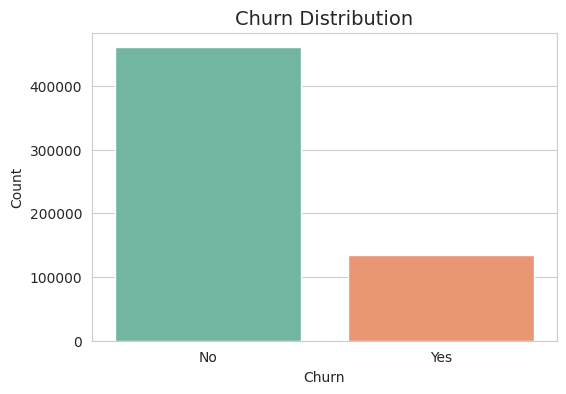

Churn
No     77.479241
Yes    22.520759
Name: proportion, dtype: float64


In [11]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='Churn', palette='Set2')
plt.title("Churn Distribution", fontsize=14)
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

print(train['Churn'].value_counts(normalize=True)*100)

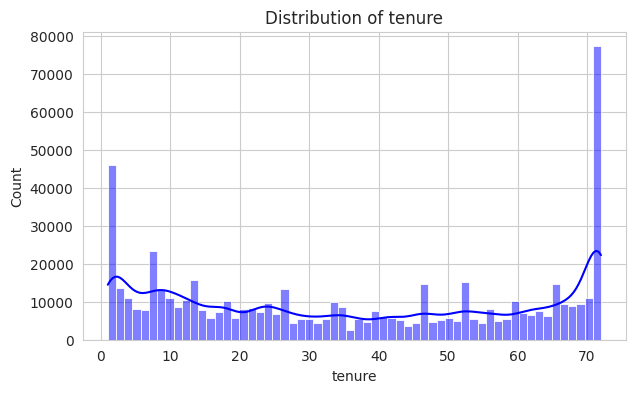

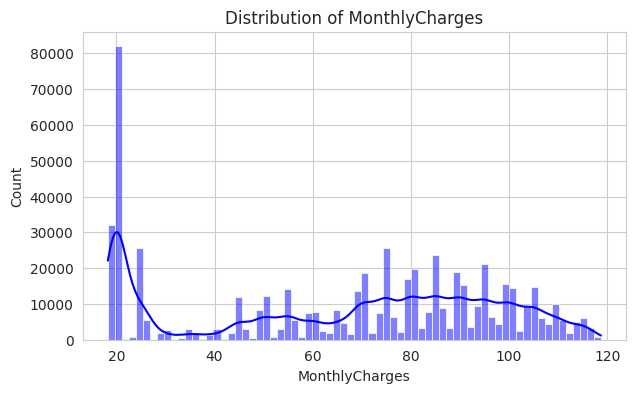

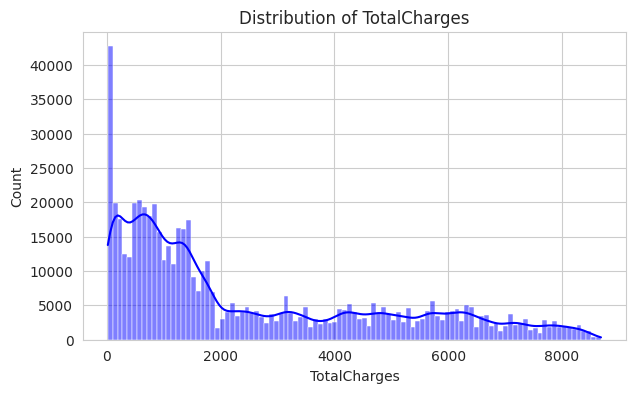

In [12]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(train[col], kde=True, color=np.random.choice(['blue','green','red','purple','orange']))
    plt.title(f"Distribution of {col}")
    plt.show()

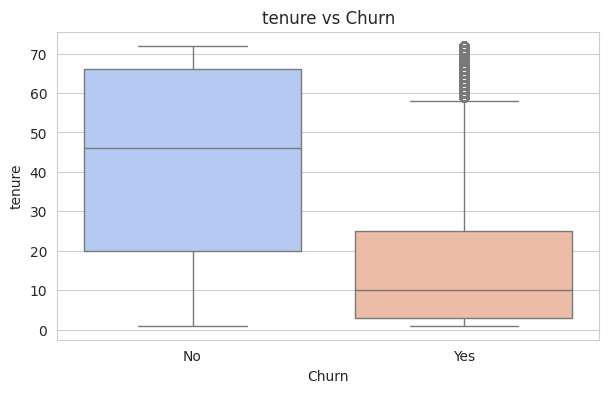

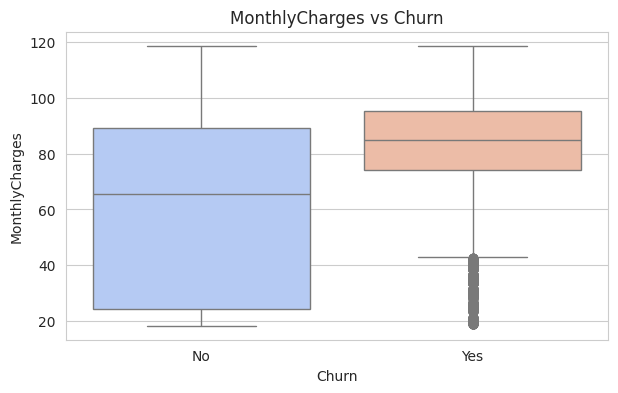

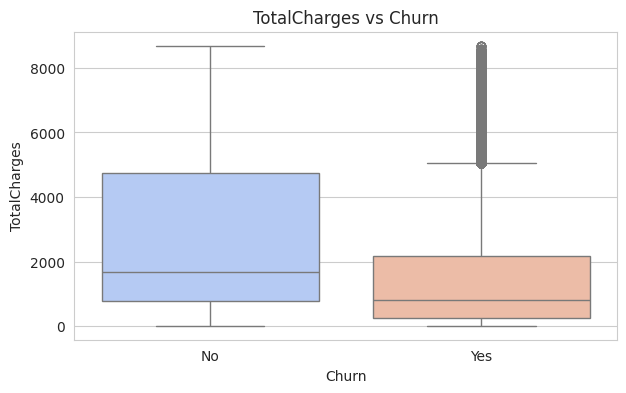

In [13]:
for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=train, x='Churn', y=col, palette='coolwarm')
    plt.title(f"{col} vs Churn")
    plt.show()

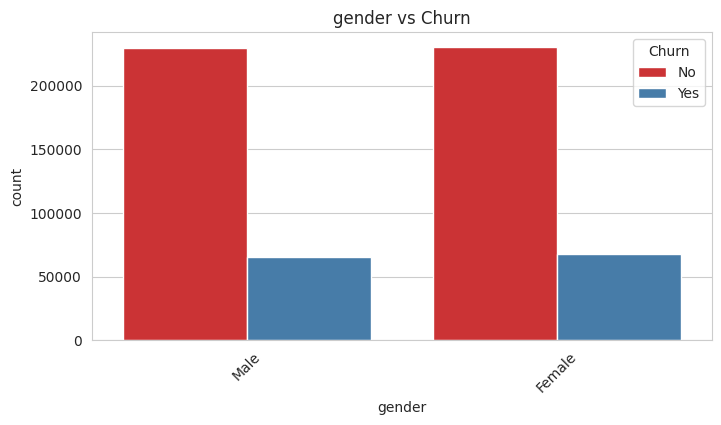

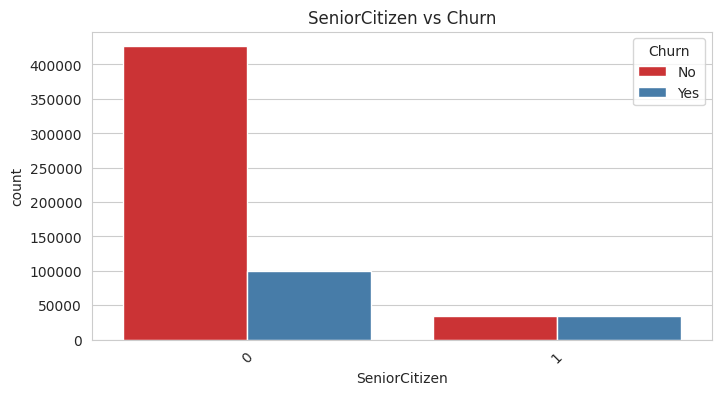

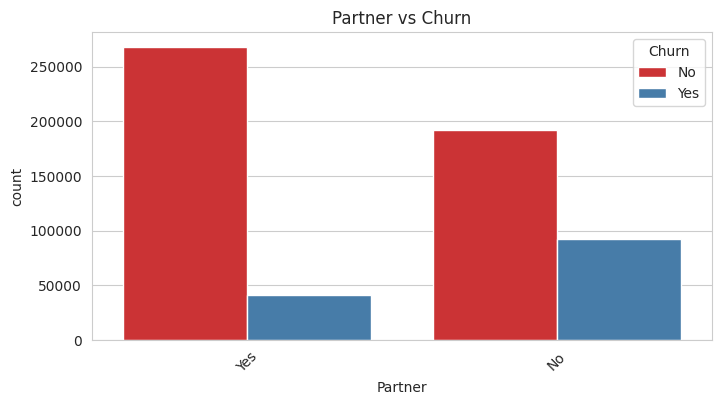

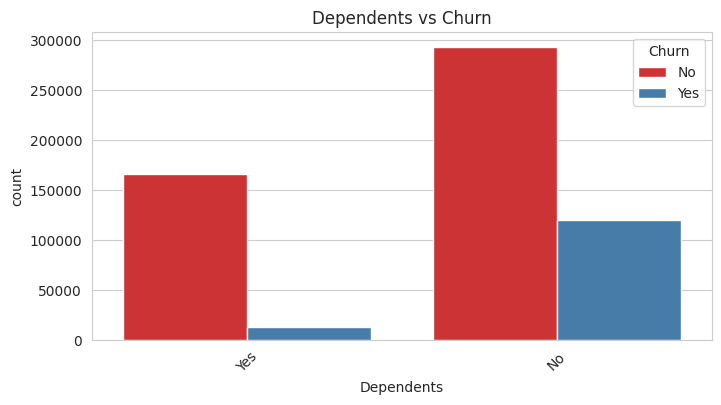

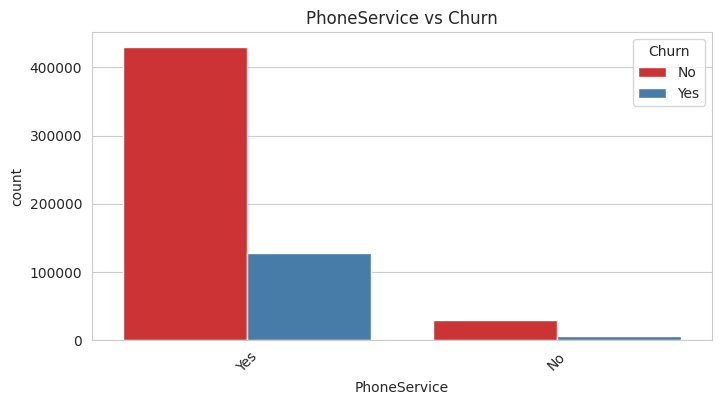

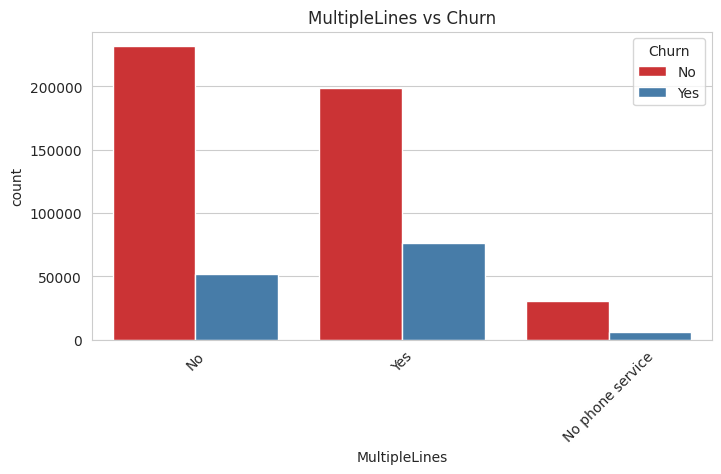

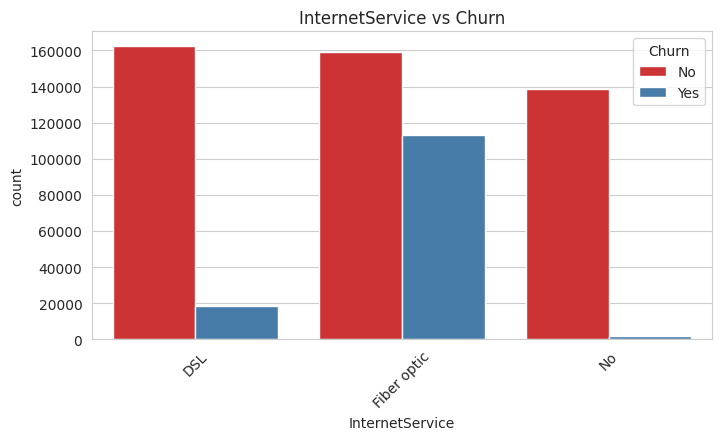

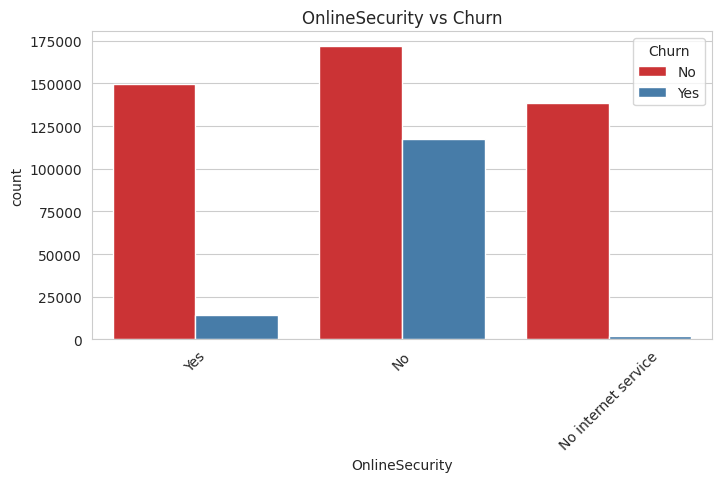

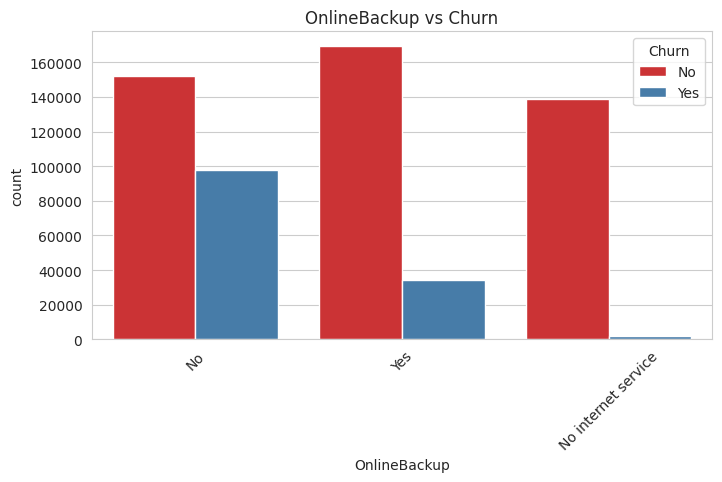

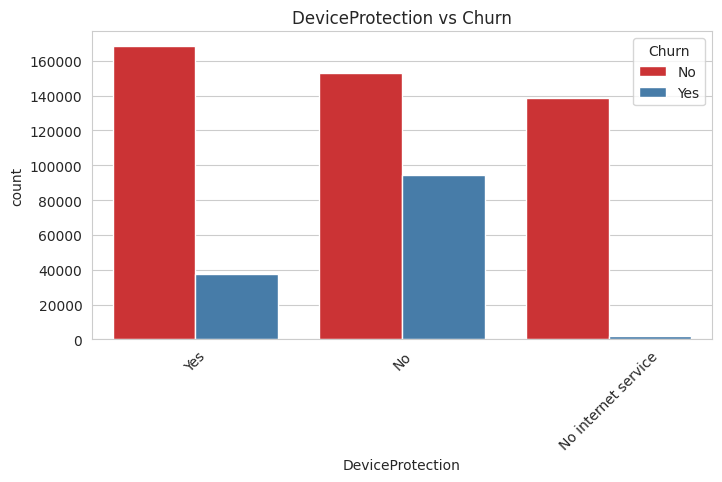

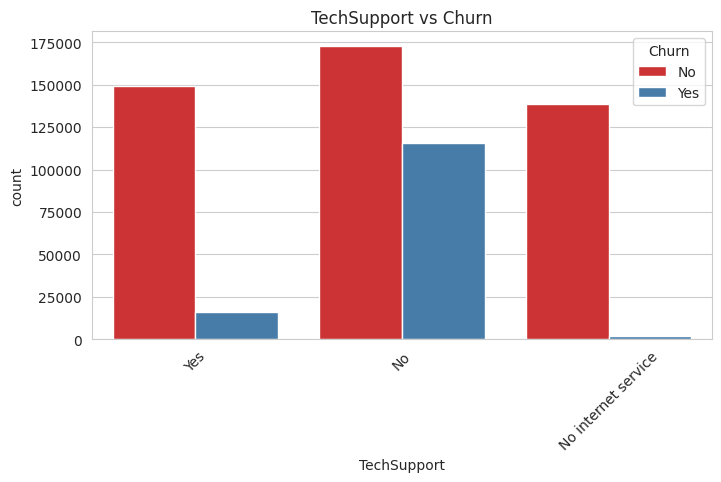

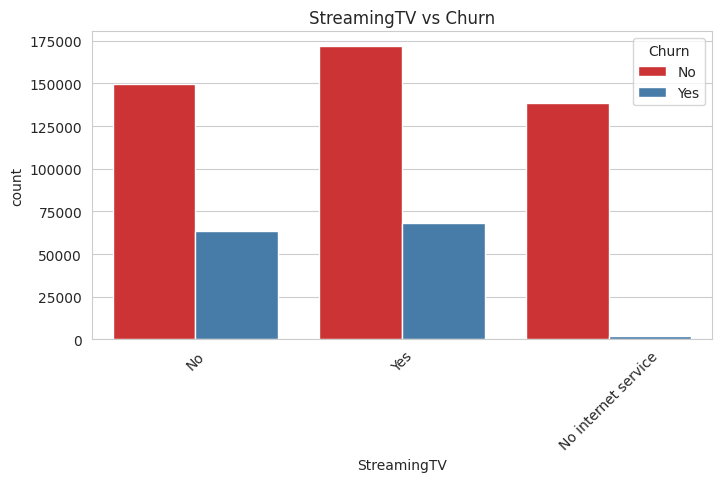

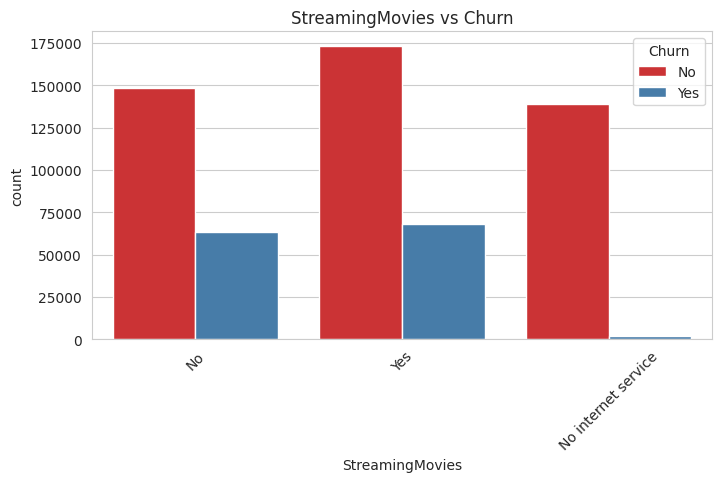

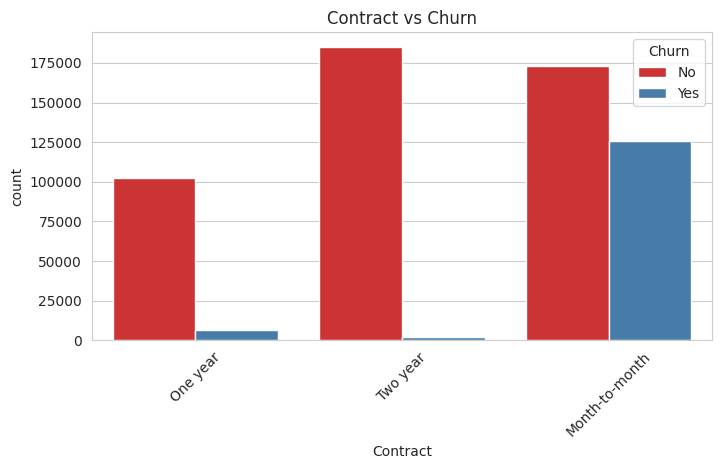

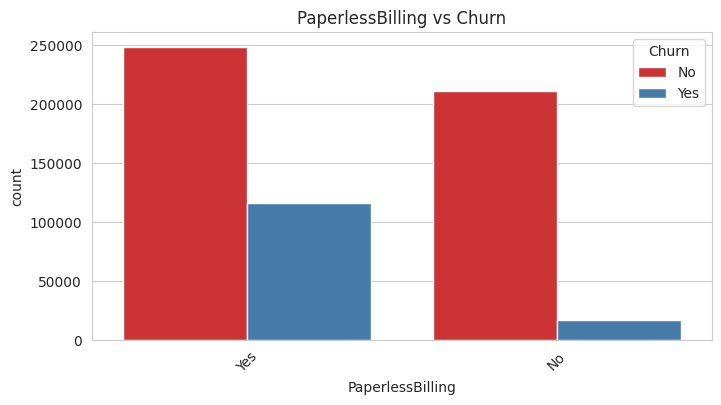

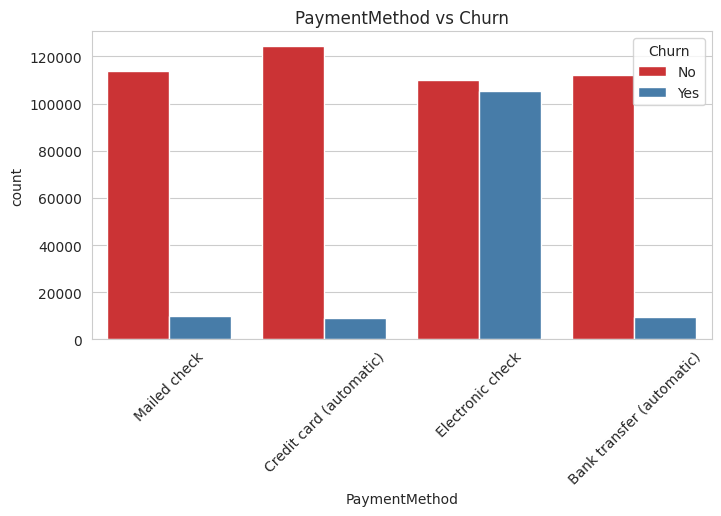

In [14]:
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
            'PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies',
            'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=train, x=col, hue='Churn', palette='Set1')
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Churn")
    plt.show()

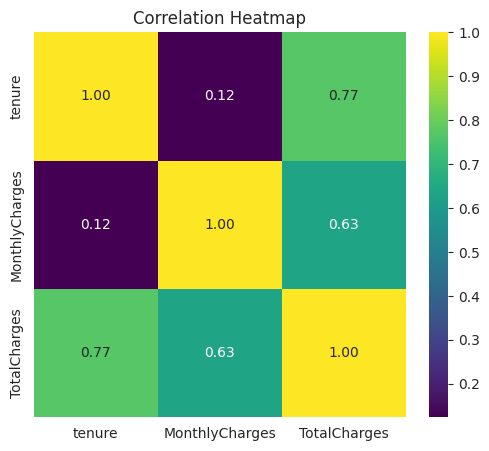

In [15]:
plt.figure(figsize=(6,5))
corr = train[['tenure','MonthlyCharges','TotalCharges']].corr()

sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

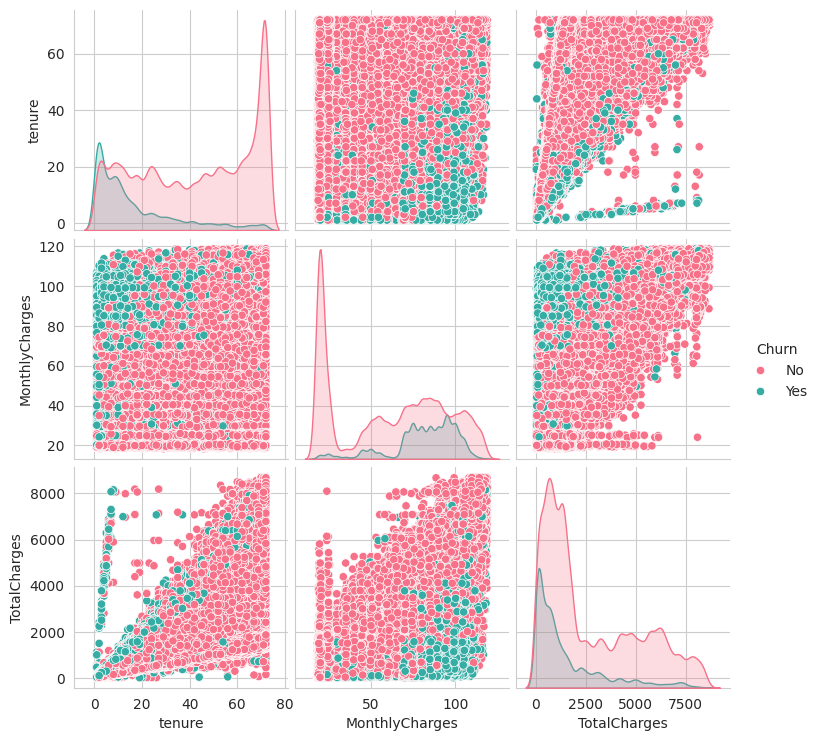

In [16]:
sns.pairplot(
    train[['tenure','MonthlyCharges','TotalCharges','Churn']],
    hue='Churn',
    palette='husl'
)
plt.show()

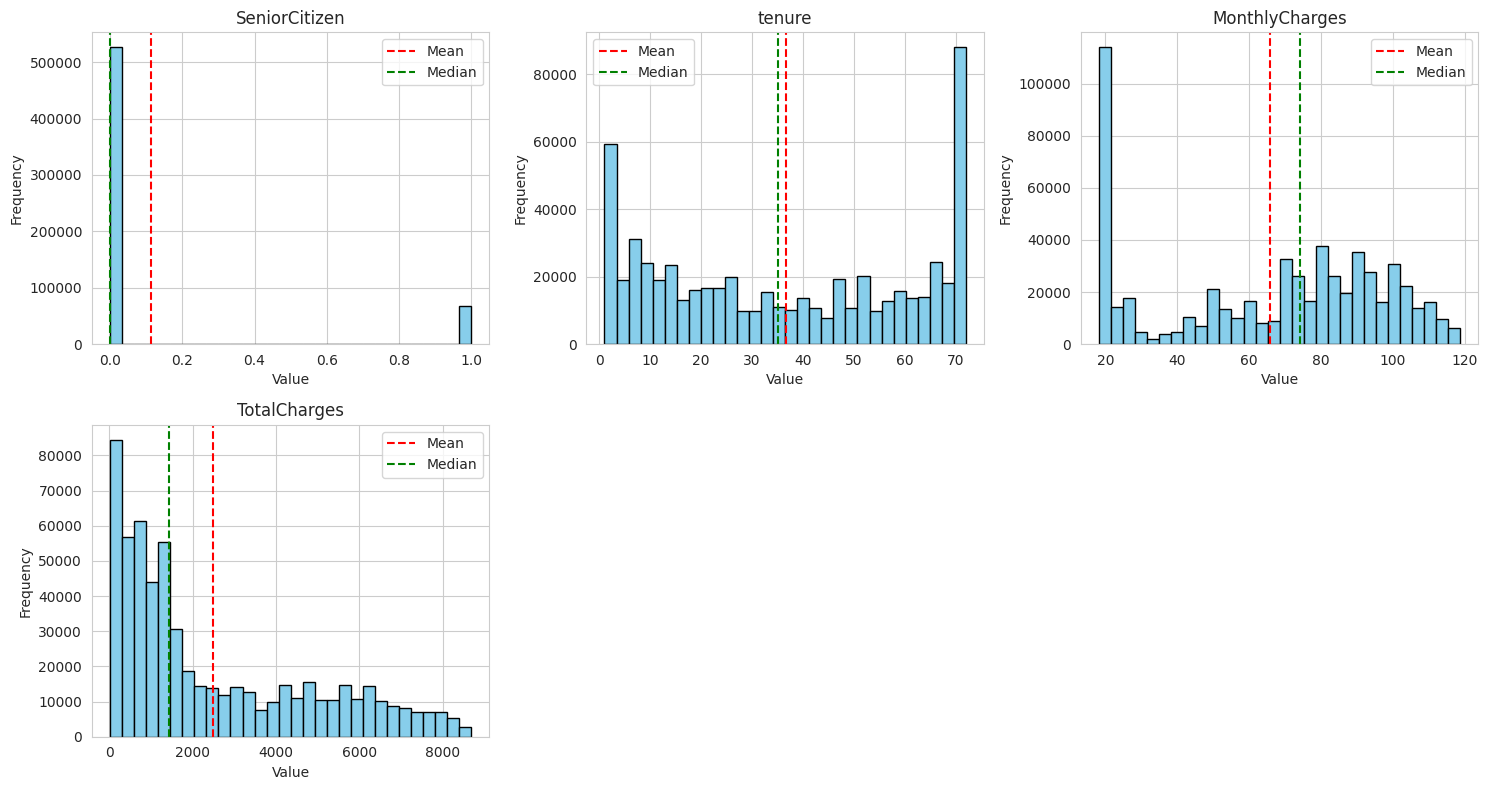

In [17]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    axes[i].hist(train[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
    
    # Mean and Median lines
    axes[i].axvline(train[col].mean(), color='red', linestyle='--', label='Mean')
    axes[i].axvline(train[col].median(), color='green', linestyle='--', label='Median')
    axes[i].legend()

# Hide extra empty plots
for j in range(len(NUMS), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [18]:
skew_kurt_df = pd.DataFrame({
    "Feature": NUMS,
    "Skewness": [train[col].skew() for col in NUMS],
    "Kurtosis": [train[col].kurt() for col in NUMS],
    "Mean": [train[col].mean() for col in NUMS],
    "Std": [train[col].std() for col in NUMS]
})

# Simple skew type classification
def skew_type(x):
    if x > 1:
        return "Highly Right"
    elif x > 0.5:
        return "Right"
    elif x < -1:
        return "Highly Left"
    elif x < -0.5:
        return "Left"
    else:
        return "Symmetric"

skew_kurt_df["Skew_Type"] = skew_kurt_df["Skewness"].apply(skew_type)

# Sort by skewness
skew_kurt_df = skew_kurt_df.sort_values("Skewness", ascending=False)

print("="*60)
print("SKEWNESS & KURTOSIS ANALYSIS")
print("="*60)

print(skew_kurt_df)

SKEWNESS & KURTOSIS ANALYSIS
          Feature  Skewness  Kurtosis         Mean          Std     Skew_Type
0   SeniorCitizen  2.427526  3.892894     0.114102     0.317936  Highly Right
3    TotalCharges  0.909169 -0.446287  2494.377057  2353.916710         Right
1          tenure  0.063050 -1.487182    36.577258    25.061922     Symmetric
2  MonthlyCharges -0.289486 -1.277955    65.866223    31.067444     Symmetric


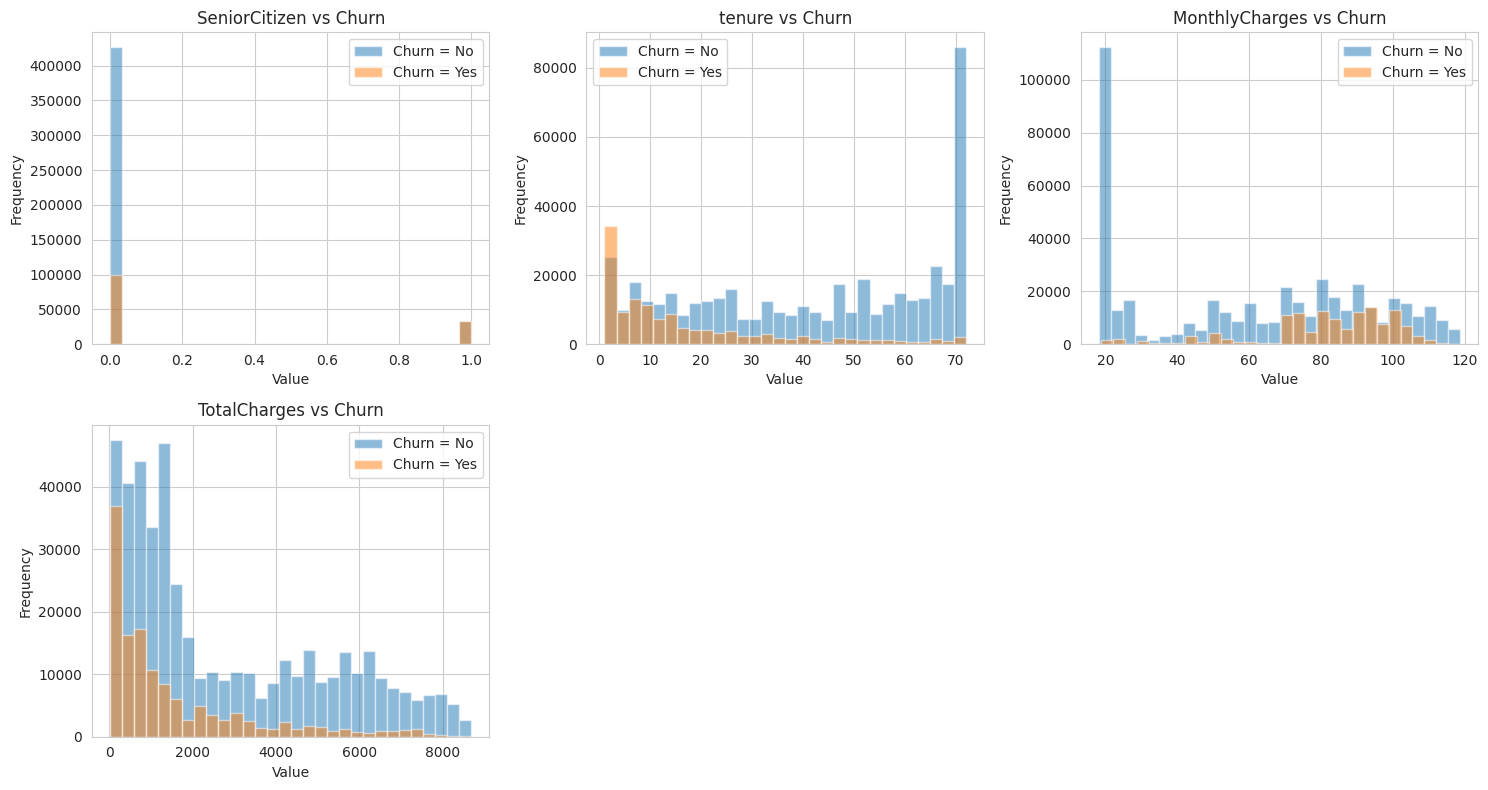

In [19]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    for target_val in train[TARGET].unique():
        data = train[train[TARGET] == target_val][col]
        axes[i].hist(data, bins=30, alpha=0.5, label=f'{TARGET} = {target_val}')
    
    axes[i].set_title(f'{col} vs {TARGET}')
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

# Hide extra empty plots
for j in range(len(NUMS), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

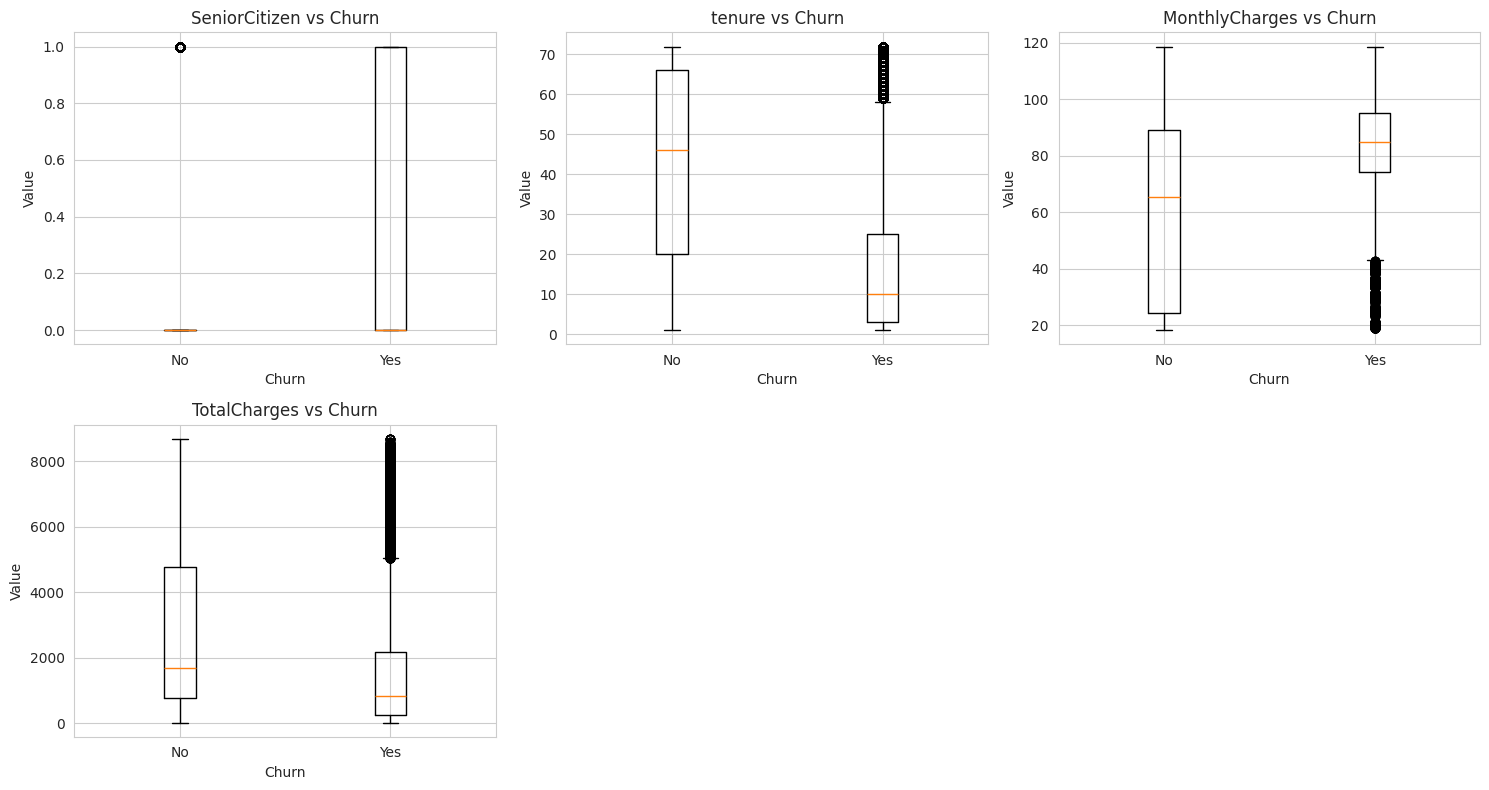

In [20]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    
    # Prepare data grouped by target
    data = [train[train[TARGET] == val][col] 
            for val in sorted(train[TARGET].unique())]
    
    axes[i].boxplot(data, labels=sorted(train[TARGET].unique()))
    
    axes[i].set_title(f"{col} vs {TARGET}")
    axes[i].set_xlabel(TARGET)
    axes[i].set_ylabel("Value")

# Hide extra empty plots
for j in range(len(NUMS), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [21]:
from scipy.stats import mannwhitneyu
print("STATISTICAL SIGNIFICANCE TEST (Numerical vs Target)")
print("-"*60)

results = []

for col in NUMS:
    # Split into two groups based on target
    group1 = train[train[TARGET] == train[TARGET].unique()[0]][col]
    group2 = train[train[TARGET] == train[TARGET].unique()[1]][col]
    
    # Mann-Whitney U Test
    stat, p_value = mannwhitneyu(group1, group2)
    
    results.append({
        "Feature": col,
        "P_Value": p_value,
        "Significant (p<0.05)": "Yes" if p_value < 0.05 else "No"
    })

# Create DataFrame
sig_df = pd.DataFrame(results).sort_values("P_Value")

print(sig_df)

# Count significant features
significant_count = sig_df[sig_df["Significant (p<0.05)"] == "Yes"].shape[0]
print(f"\nSignificant Features: {significant_count}/{len(NUMS)}")

STATISTICAL SIGNIFICANCE TEST (Numerical vs Target)
------------------------------------------------------------
          Feature  P_Value Significant (p<0.05)
0   SeniorCitizen      0.0                  Yes
1          tenure      0.0                  Yes
2  MonthlyCharges      0.0                  Yes
3    TotalCharges      0.0                  Yes

Significant Features: 4/4


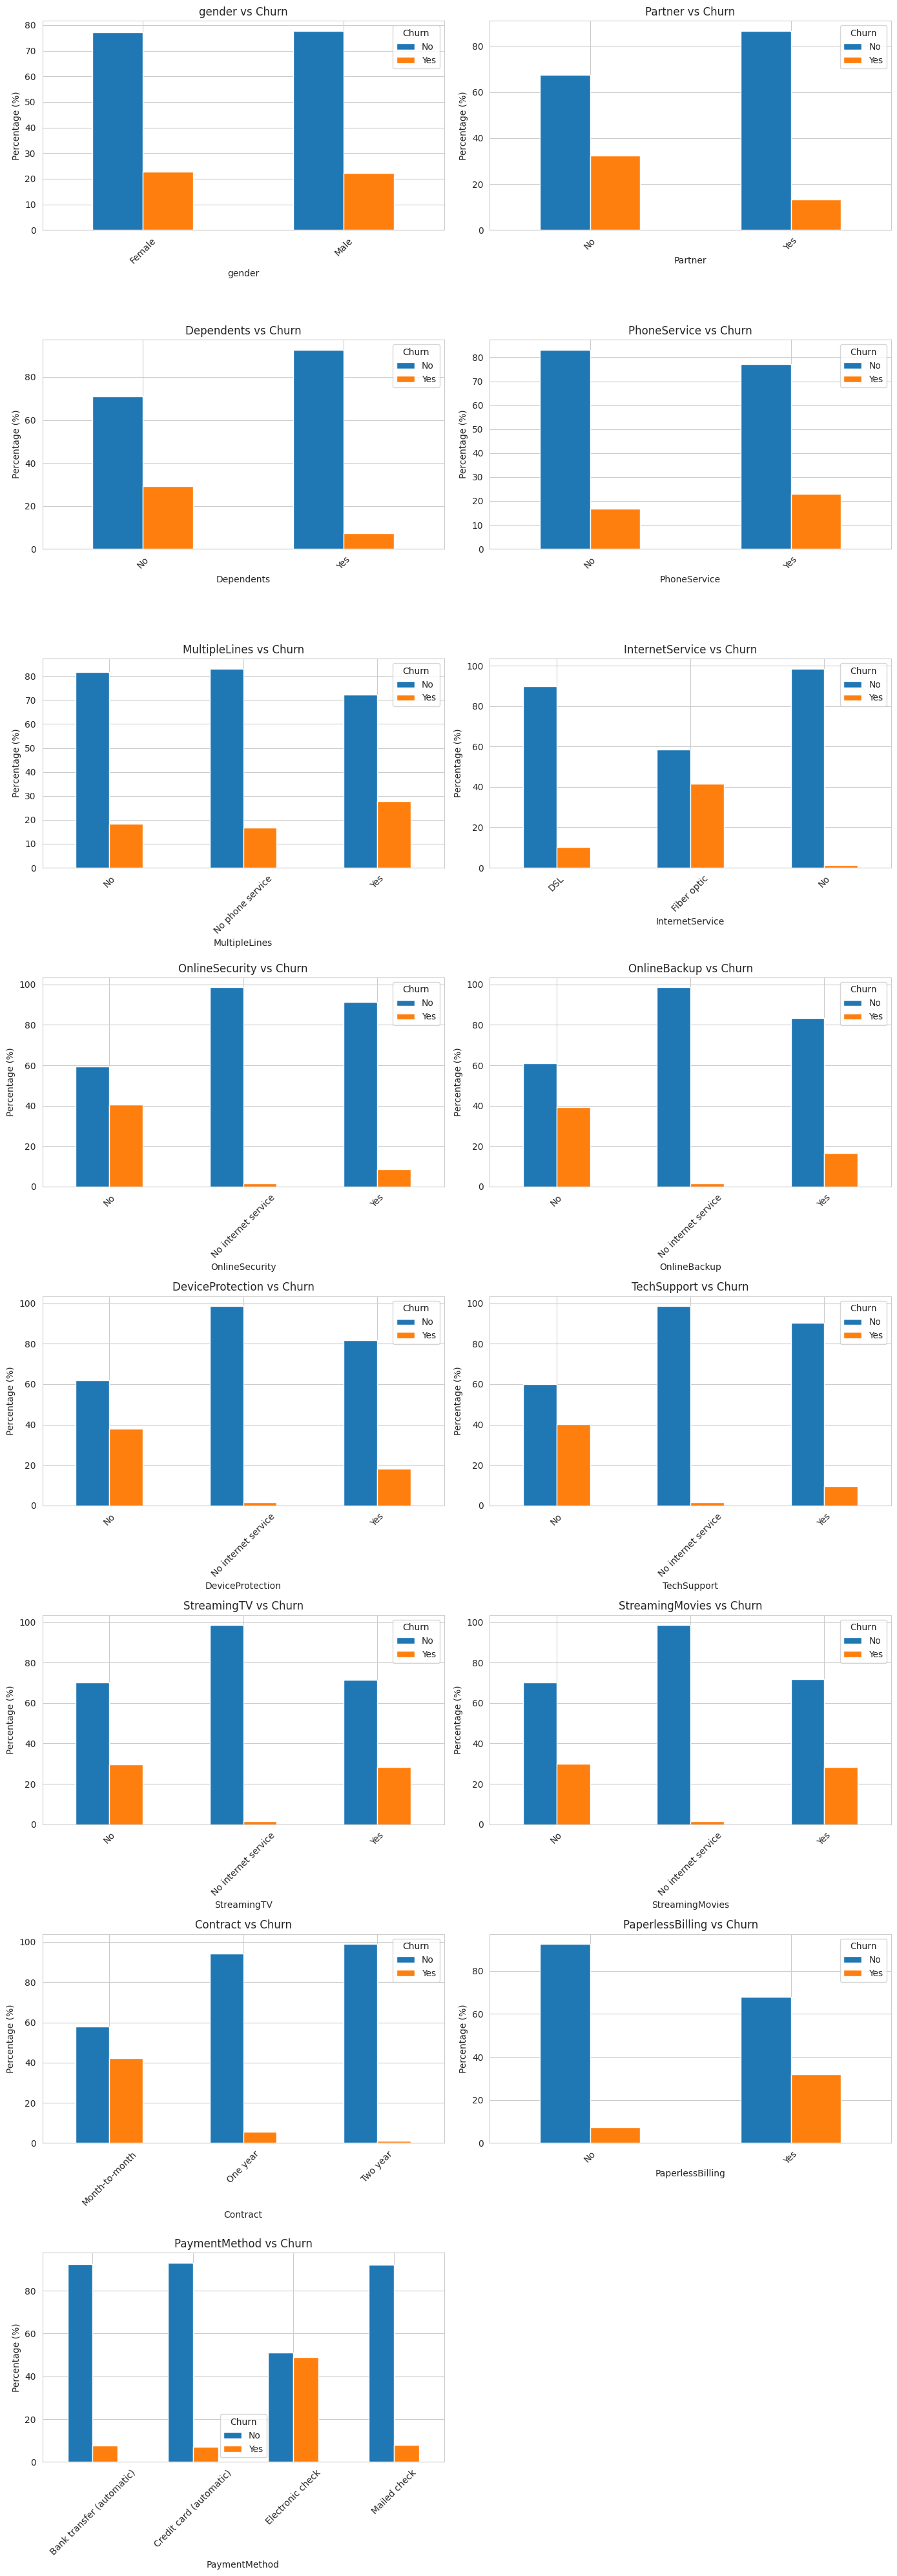

In [22]:
from scipy.stats import chi2_contingency

if len(CATS) > 0:
    
    n_cols = 2
    n_rows = (len(CATS) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(CATS):
        # Percentage table
        ct = pd.crosstab(train[col], train[TARGET], normalize='index') * 100
        
        ct.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f"{col} vs {TARGET}")
        axes[i].set_ylabel("Percentage (%)")
        axes[i].set_xlabel(col)
        axes[i].legend(title=TARGET)
        axes[i].tick_params(axis='x', rotation=45)
    
    # Hide empty plots
    for j in range(len(CATS), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [23]:
from scipy.stats import chi2_contingency

if len(CATS) > 0:
    
   
    print("CHI-SQUARE TEST (Categorical vs Target)")
    print("-"*60)

    results = []

    for col in CATS:
        ct = pd.crosstab(train[col], train[TARGET])
        chi2, p_value, dof, _ = chi2_contingency(ct)

        results.append({
            "Feature": col,
            "P_Value": p_value,
            "Significant (p<0.05)": "Yes" if p_value < 0.05 else "No"
        })

    chi_df = pd.DataFrame(results).sort_values("P_Value")
    print(chi_df)

else:
    print("No categorical features to analyze.")

CHI-SQUARE TEST (Categorical vs Target)
------------------------------------------------------------
             Feature        P_Value Significant (p<0.05)
1            Partner   0.000000e+00                  Yes
2         Dependents   0.000000e+00                  Yes
5    InternetService   0.000000e+00                  Yes
4      MultipleLines   0.000000e+00                  Yes
6     OnlineSecurity   0.000000e+00                  Yes
7       OnlineBackup   0.000000e+00                  Yes
9        TechSupport   0.000000e+00                  Yes
8   DeviceProtection   0.000000e+00                  Yes
12          Contract   0.000000e+00                  Yes
13  PaperlessBilling   0.000000e+00                  Yes
10       StreamingTV   0.000000e+00                  Yes
11   StreamingMovies   0.000000e+00                  Yes
14     PaymentMethod   0.000000e+00                  Yes
3       PhoneService  8.013132e-159                  Yes
0             gender   1.561934e-07         

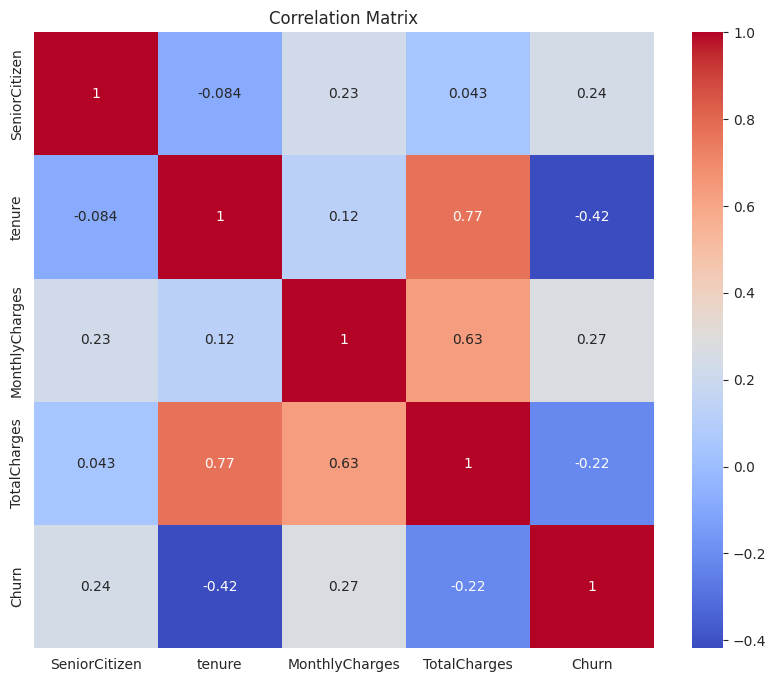

In [24]:
# Copy numerical + target
corr_data = train[NUMS + [TARGET]].copy()

# Convert target to numeric if needed
if corr_data[TARGET].dtype == 'object':
    corr_data[TARGET] = corr_data[TARGET].astype('category').cat.codes

# Correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [25]:
print("HIGH CORRELATIONS (|r| > 0.7)")
print("-"*50)

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        
        if abs(corr_value) > 0.7:
            print(f"{corr_matrix.columns[i]} & {corr_matrix.columns[j]} → {corr_value:.2f}")

HIGH CORRELATIONS (|r| > 0.7)
--------------------------------------------------
tenure & TotalCharges → 0.77


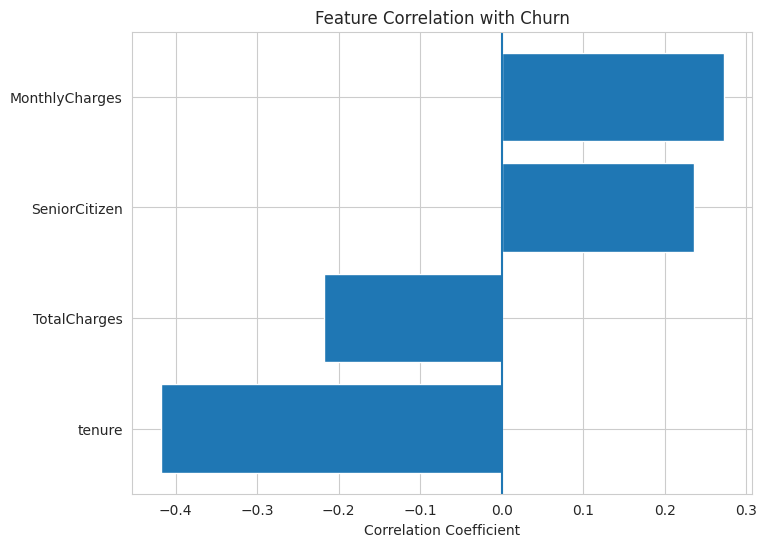

In [26]:
target_corr = corr_matrix[TARGET].drop(TARGET).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,6))
plt.barh(target_corr.index, target_corr.values)
plt.xlabel("Correlation Coefficient")
plt.title(f"Feature Correlation with {TARGET}")
plt.axvline(0)  # vertical line at 0
plt.gca().invert_yaxis()  # highest correlation at top
plt.show()

In [27]:
print("TOP 5 POSITIVE CORRELATIONS")
print("-"*50)
print(target_corr.head())

TOP 5 POSITIVE CORRELATIONS
--------------------------------------------------
MonthlyCharges    0.272997
SeniorCitizen     0.236362
TotalCharges     -0.218365
tenure           -0.418453
Name: Churn, dtype: float64


In [28]:
print("\n" + "-"*50)
print("TOP 5 NEGATIVE CORRELATIONS")
print(target_corr.tail())


--------------------------------------------------
TOP 5 NEGATIVE CORRELATIONS
MonthlyCharges    0.272997
SeniorCitizen     0.236362
TotalCharges     -0.218365
tenure           -0.418453
Name: Churn, dtype: float64


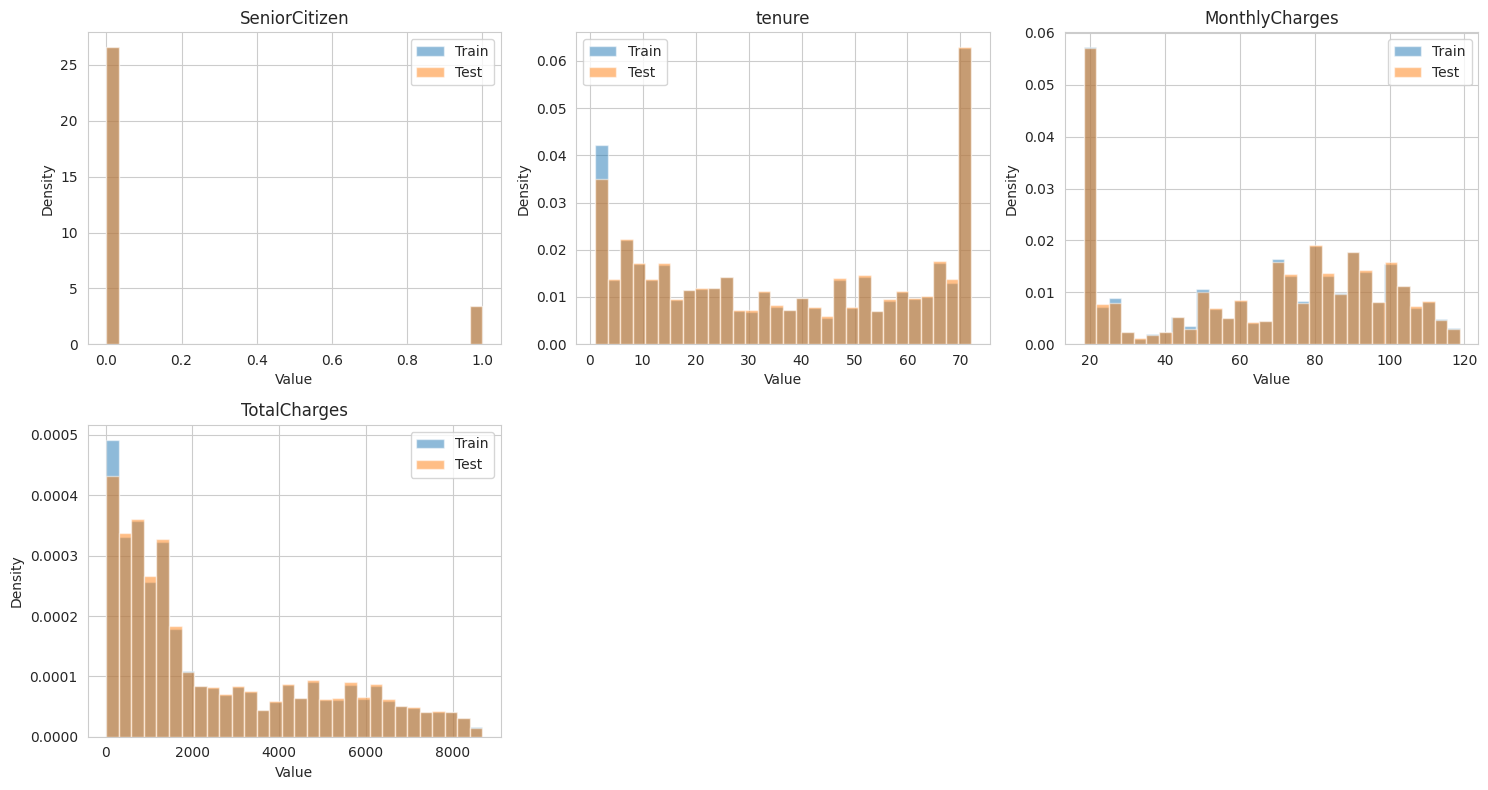

In [29]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    
    # Train histogram
    axes[i].hist(train[col], bins=30, alpha=0.5, label="Train", density=True)
    
    # Test histogram
    axes[i].hist(test[col], bins=30, alpha=0.5, label="Test", density=True)
    
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].legend()

# Hide extra empty plots
for j in range(len(NUMS), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [30]:
from scipy.stats import ks_2samp

print("KS TEST (Train vs Test)")
print("-"*60)

results = []

for col in NUMS:
    stat, p_value = ks_2samp(train[col], test[col])
    
    results.append({
        "Feature": col,
        "P_Value": p_value,
        "Same Distribution (p>0.05)": "Yes" if p_value > 0.05 else "No"
    })

ks_df = pd.DataFrame(results).sort_values("P_Value", ascending=False)

print(ks_df)

# Count aligned features
aligned = ks_df[ks_df["Same Distribution (p>0.05)"] == "Yes"].shape[0]
print(f"\nAligned Features: {aligned}/{len(NUMS)}")

KS TEST (Train vs Test)
------------------------------------------------------------
          Feature       P_Value Same Distribution (p>0.05)
0   SeniorCitizen  1.000000e+00                        Yes
2  MonthlyCharges  4.945145e-07                         No
1          tenure  1.550134e-45                         No
3    TotalCharges  5.383638e-49                         No

Aligned Features: 1/4


## Feature engg

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [32]:
X = train.drop(columns=[TARGET, "id"])
y = (train[TARGET] == "Yes").astype(int)

X_test = test.drop(columns=["id"])

# Ensure categorical columns are string type
for col in CATS:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Get categorical feature indices (IMPORTANT FIX)
cat_features_idx = [X.columns.get_loc(col) for col in CATS]

In [33]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_pred = np.zeros(len(X))
test_pred = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    
    print(f"\n===== Fold {fold+1} =====")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.03,
        eval_metric="AUC",
        auto_class_weights="Balanced",
        random_state=42,
        verbose=False
    )

    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        cat_features=cat_features_idx
    )

    val_pred = model.predict_proba(X_val)[:,1]
    oof_pred[val_idx] = val_pred
    
    test_pred += model.predict_proba(X_test)[:,1] / skf.n_splits
    
    print("Fold AUC:", roc_auc_score(y_val, val_pred))

print("\nFinal CV AUC:", roc_auc_score(y, oof_pred))


===== Fold 1 =====
Fold AUC: 0.9157555457441336

===== Fold 2 =====
Fold AUC: 0.9168764461931385

===== Fold 3 =====
Fold AUC: 0.9162496448781929

===== Fold 4 =====
Fold AUC: 0.9173066937229479

===== Fold 5 =====
Fold AUC: 0.9146607431292524

Final CV AUC: 0.916161227906117


In [34]:
submission = pd.DataFrame({
    "id": test["id"],
    TARGET: test_pred
})

submission.to_csv("submission.csv", index=False)
print("Submission created successfully!")

Submission created successfully!


## Thank you..pls upvote!!!!